In [ ]:
import networkx as nx
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
from relevant_functions import Granover_methods as GM
Random_seed = 42
random.seed(Random_seed)
np.random.seed(Random_seed)

In [2]:
#store nodes and edges data
def load_data(nodes, edges):

    nodes = pd.read_csv(nodes)
    edges = pd.read_csv(
        edges,
        header=None,
        names=["source_new_id", "target_new_id"],
    )
    # merge to get page names
    df_merged = (
        edges
        .merge(nodes[['new_id', 'name']], left_on='source_new_id', right_on='new_id')
        .rename(columns={'name': 'page_name_1'})
        .drop('new_id', axis=1)
        .merge(nodes[['new_id', 'name']], left_on='target_new_id', right_on='new_id')
        .rename(columns={'name': 'page_name_2'})
        .drop('new_id', axis=1)
        .rename(columns={
            'source_new_id': 'page_id_1',
            'target_new_id': 'page_id_2'
        })
    )
    print(nodes.size)
    print(edges.size)
    return df_merged, nodes, edges

In [3]:
#threadpullexecuter
df_merged, nodes, edges = load_data("fb-pages-public-figure.nodes", "fb-pages-public-figure.edges")

34677
134228


In [4]:
def create_facebookpage_network(df):
    """
    Create a network graph from Facebook page data.
    
    Args:
        df (pandas.DataFrame): Facebook page data
        
    Returns:
        networkx.Graph: Undirected graph of Facebook page connections
    """
    print("Creating Facebook page network...")
    
    # Create undirected graph (dataset shows pages in bidirectional connections)
    G = nx.Graph()
    
    # Add edges for each route
    for _, row in df.iterrows():
        source = row['page_name_1']
        dest = row['page_name_2']

        # Skip self-loops
        if source != dest:
            if G.has_edge(source, dest):
                # Increment weight if edge already exists
                G[source][dest]['weight'] += 1
            else:
                # Add new edge with weight 1
                G.add_edge(source, dest, weight=1)

    print(f"Network created with {G.number_of_nodes()} facebook pages and {G.number_of_edges()} connections")

    return G

In [5]:
G = create_facebookpage_network(df_merged)

Creating Facebook page network...
Network created with 11534 facebook pages and 66942 connections


In [ ]:
#define parameters for simulation
#nr of nodes
n = G.number_of_nodes()
#choose treshold distribution as beta
# choose second treshold distribution as constant for comparison
treshold_distribution = 'beta'
treshold_distribution2 = 'constant'
#seed fractions 0.005, 0.01 and 0.05 to see difference in spread
seed_fractions = [0.005,0.01,0.05]

#10 repetitions for reducing stochasticity
R = 10
#To save time, choose 100 as max steps, let's see if this is enough for convergence 
max_steps = 100

In [ ]:
#unncomment to run simulations again
# betweenness_gr = nx.betweenness_centrality(G, seed=42)
# #save it so i can use it later
# np.save('betweenness_gr.npy', betweenness_gr)

In [67]:
#load precomputed betweenness approximation
betweenness_gr = np.load('betweenness_gr.npy', allow_pickle=True).item()


In [68]:
#redefine betweenness seeds function to use precomputed betweenness
def betweenness_seeds_precomputed(G, B,betweenness):
     return sorted(betweenness, key=betweenness.get, reverse=True)[:B]

In [82]:
#draw tresholds for each node in G based on treshold distribution
tresholds = GM.draw_thresholds(G, mode=treshold_distribution, phi_mean=0.3, phi_std=0.1)
#draw tresholds for constant distribution with threshold 0.3
tresholds2 = GM.draw_thresholds(G, mode=treshold_distribution2, phi_mean=0.3, phi_std=0.1)

In [ ]:
#k-core not required and greedy takes too much time
strategies = {
    "Random": lambda B: GM.random_seeds(G, B),
    "Degree": lambda B: GM.high_degree_seeds(G, B),
    "Betweenness": lambda B: betweenness_seeds_precomputed(G, B, betweenness_gr)
}

In [ ]:
#uncomment to run simulations again
# """
# calculates B, the number of initial adopters. for each seeding strategy (Random, Degree, Betweenness) 
# run R independent simulations of the threshold dynamics.
# each simulation involves: selection of seeds according to the strategy,
# adoption over time, measurement of final outcome and speed of adoption spread
# stores full adoption curve for each simulation in results list
# then calculate the final adoption fraction, time till 50% adoption,
# and the shape of adoption dynamics (history) per seeding strategy

# """
# def run_simulation(tresholds):
#     results = []
    
#     for seed in seed_fractions:
#         B = int(seed * n)  #number of seeds based on fraction
#         print(f"Running simulations for seed fraction: {seed} ({B} seeds)")
        
#         for strategy_name, seeds_strategy in strategies.items():
#             print(f"  Strategy: {strategy_name}")

#             #degree and betweenness use precomputed values
#             #for random we get new seeds each repetition
#             for r in range(R):
#                 # pick seeds
#                 seeds = seeds_strategy(B)

#                 #run threshold dynamics
#                 adopted_seeds, history = GM.threshold_dynamics(G, seeds, tresholds, max_steps=max_steps)

#                 #metrics
#                 final_adopted = GM.final_adoption_fraction(adopted_seeds)
#                 time_to_50 = GM.time_to_fraction(history, target=0.5)

#                 results.append({
#                     "Seed_Fraction": seed,
#                     "Strategy": strategy_name,
#                     "Repetition": r + 1,
#                     "B": B,
#                     "Final_Adoption_Fraction": final_adopted,
#                     "Time_to_50%_Adoption": time_to_50,
#                     "history": history
#                 })
#     return results 
# results = run_simulation(tresholds)
# results2 = run_simulation(tresholds2)
# #store results in dataframe
# results_df = pd.DataFrame(results)
# results_const = pd.DataFrame(results2)
# np.save('results_df.npy', results_df)
# np.save('results_const.npy', results_const)
# #store column names
# columns_list = results_df.columns.tolist()
# with open("column_names.txt", "w") as f:
#     for col in columns_list:
#         f.write(col + "\n")

Running simulations for seed fraction: 0.005 (57 seeds)
  Strategy: Random


NameError: name 'rng' is not defined

In [91]:
#load results
results_df = pd.DataFrame(np.load('results_df.npy', allow_pickle=True))
results_df2 = pd.DataFrame(np.load('results_const.npy', allow_pickle=True))
with open("column_names.txt", "r") as f:
    column_names = f.readlines()
column_names = [col.strip() for col in column_names]
results_df.columns = column_names
results_df2.columns = column_names
results_df.head()

,Seed_Fraction,Strategy,Repetition,B,Final_Adoption_Fraction,Time_to_50%_Adoption,history
0,0.005,Random,1,57,0.978065,21.0,"[0.004941910872203919, 0.010317322698109936, 0..."
1,0.005,Random,2,57,0.978238,22.0,"[0.004941910872203919, 0.009710421362926998, 0..."
2,0.005,Random,3,57,0.977024,19.0,"[0.004941910872203919, 0.01153112536847581, 0...."
3,0.005,Random,4,57,0.976938,22.0,"[0.004941910872203919, 0.01170452574995665, 0...."
4,0.005,Random,5,57,0.978152,17.0,"[0.004941910872203919, 0.013178428992543784, 0..."


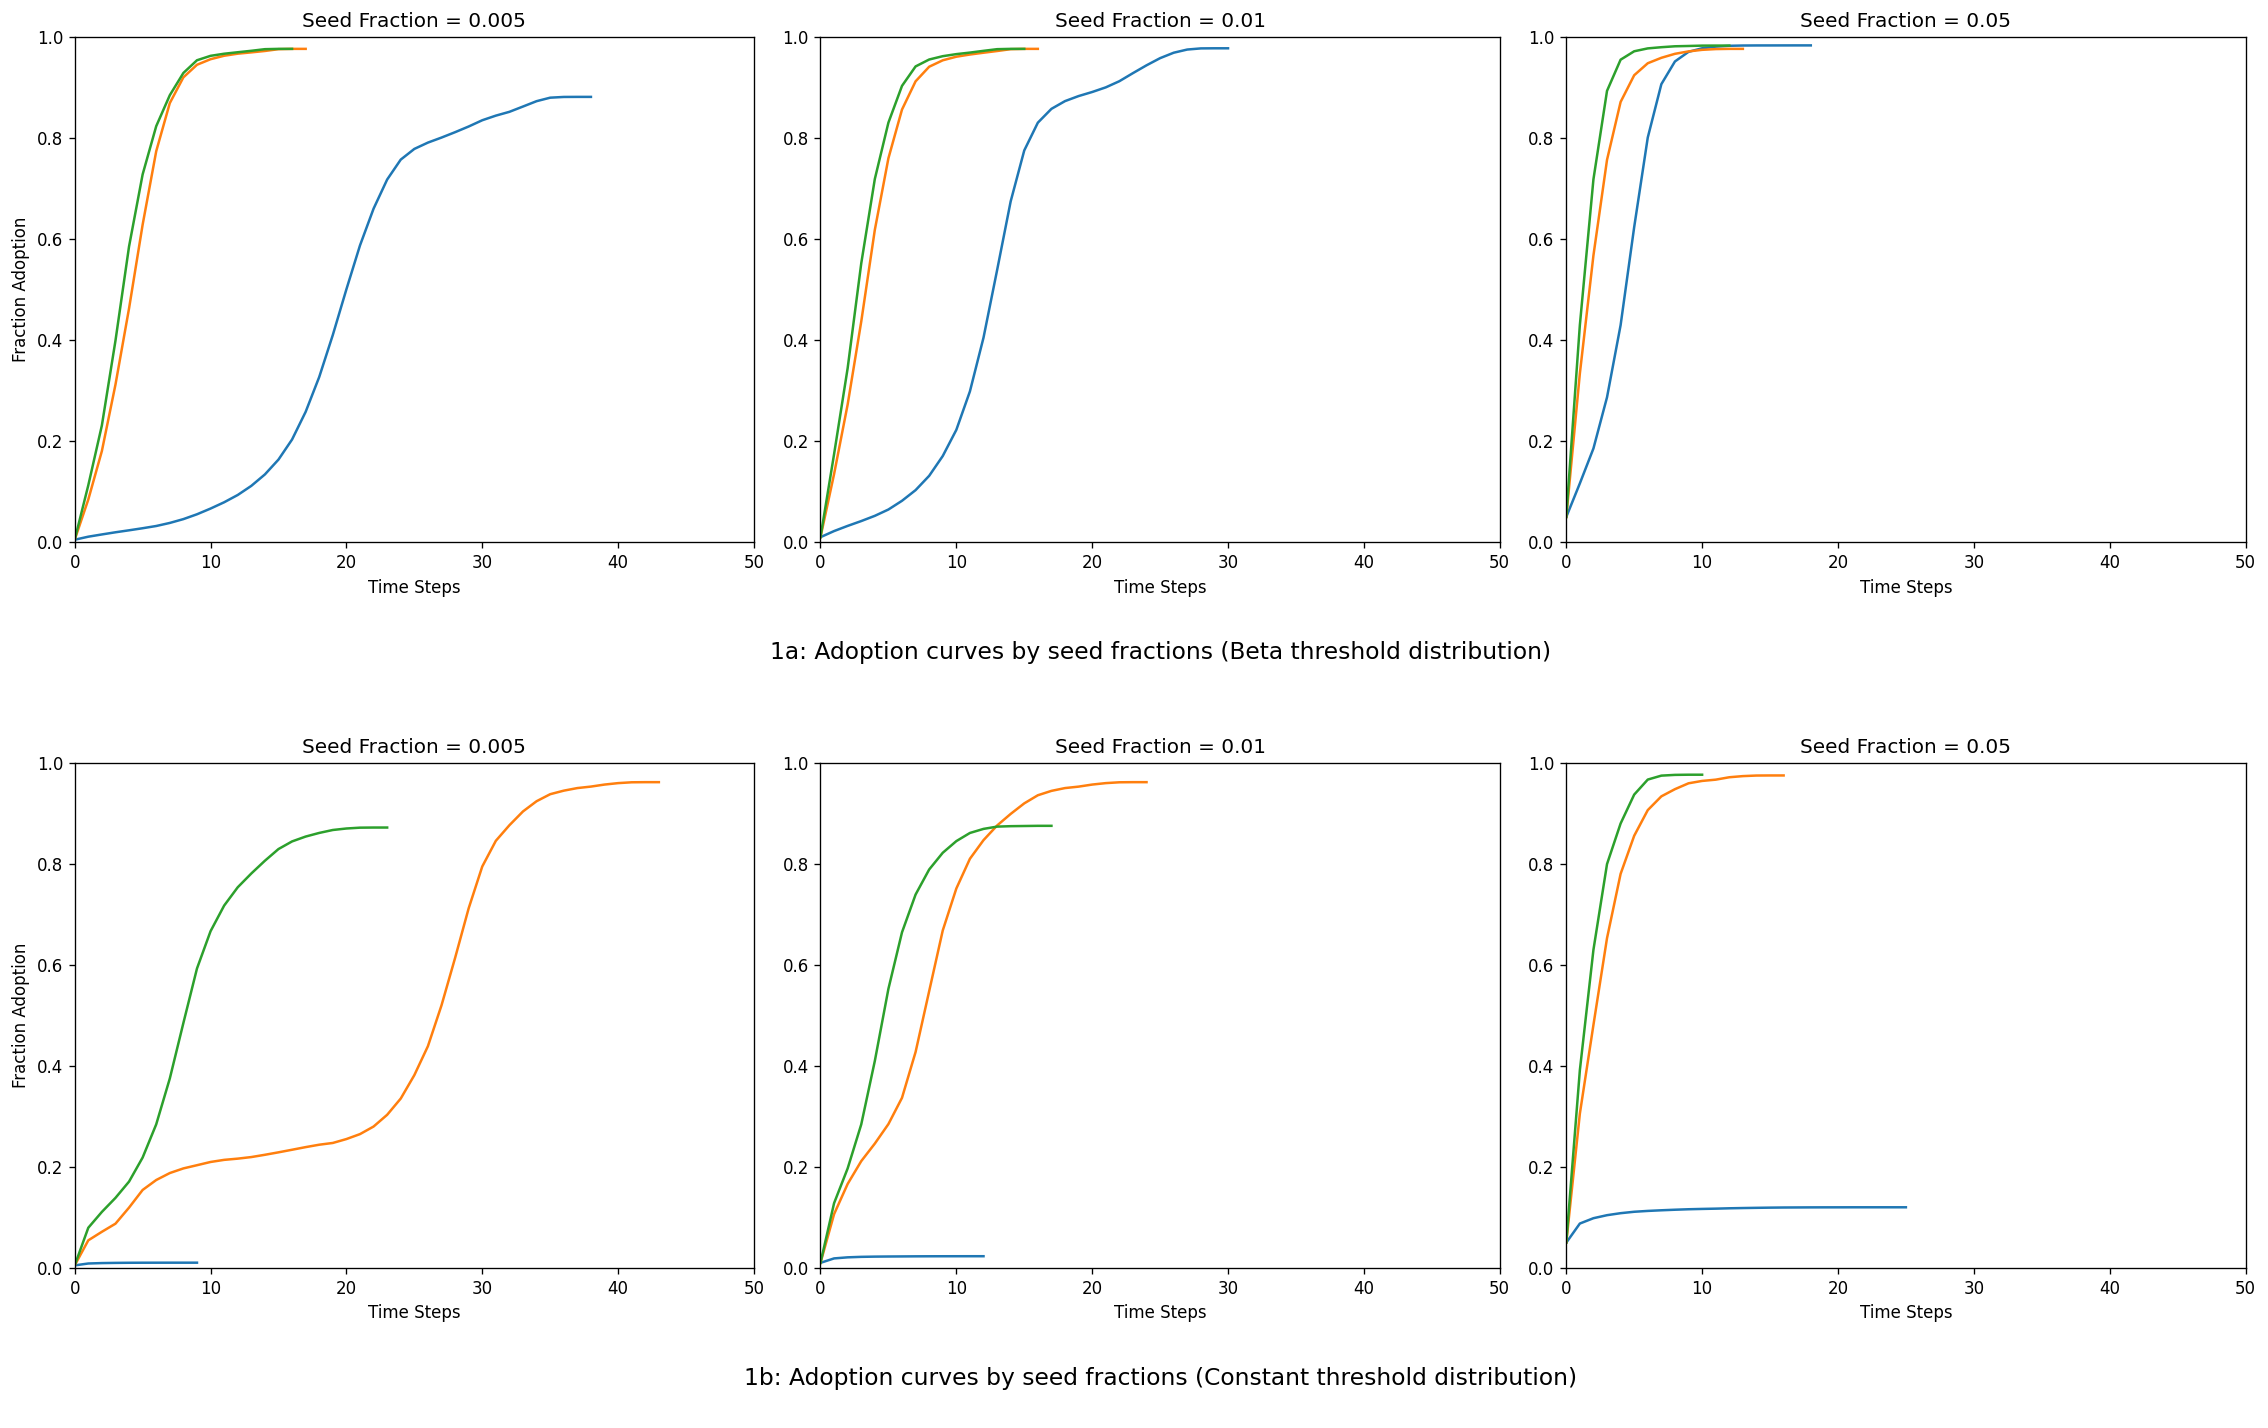

In [ ]:
def plot_adoption_curves_combined(results_df_beta, results_df_const):
    fig = plt.figure(figsize=(20, 12))

    #2 rows of plots + 2 caption rows
    gs = fig.add_gridspec(4, 3, height_ratios=[1, 0.15, 1, 0.15])

    #add row
    def add_row(results_df, row_index, title_text):
        for i, seed_frac in enumerate(seed_fractions):
            ax = fig.add_subplot(gs[row_index, i])
            subset = results_df[results_df["Seed_Fraction"] == seed_frac]
            #take average history per strategy
            for strategy in ["Random", "Degree", "Betweenness"]:
                histories = subset[subset["Strategy"] == strategy]["history"].tolist()
                if not histories:
                    continue
                #lengths histories the same
                max_len = max(len(h) for h in histories)
                padded = [(np.concatenate([h, np.full(max_len - len(h), h[-1])])
                           if len(h) < max_len else h) for h in histories]

                mean_history = np.mean(padded, axis=0)
                ax.plot(mean_history, label=strategy)
            #set titles and labels
            ax.set_title(f"Seed Fraction = {seed_frac}")
            ax.set_ylim(0, 1)
            ax.set_xlim(0, 50)
            ax.set_xlabel("Time Steps")
            if i == 0:
                ax.set_ylabel("Fraction Adoption")

        # Caption row (center text)
        cap_ax = fig.add_subplot(gs[row_index + 1, :])
        cap_ax.axis("off")
        cap_ax.text(
            0.5, 0.5,
            title_text,
            ha='center', va='center', fontsize=14
        )

    add_row(results_df_beta, 0, "1a: Adoption curves by seed fractions (Beta threshold distribution)")

    add_row(results_df_const, 2, "1b: Adoption curves by seed fractions (Constant threshold distribution)")


    plt.tight_layout(rect=[0, 0, 0.95, 1]) 
    plt.savefig("adoption_curves_combined.png", dpi=300, bbox_inches="tight")
    plt.show()
plot_adoption_curves_combined(results_df, results_df2)

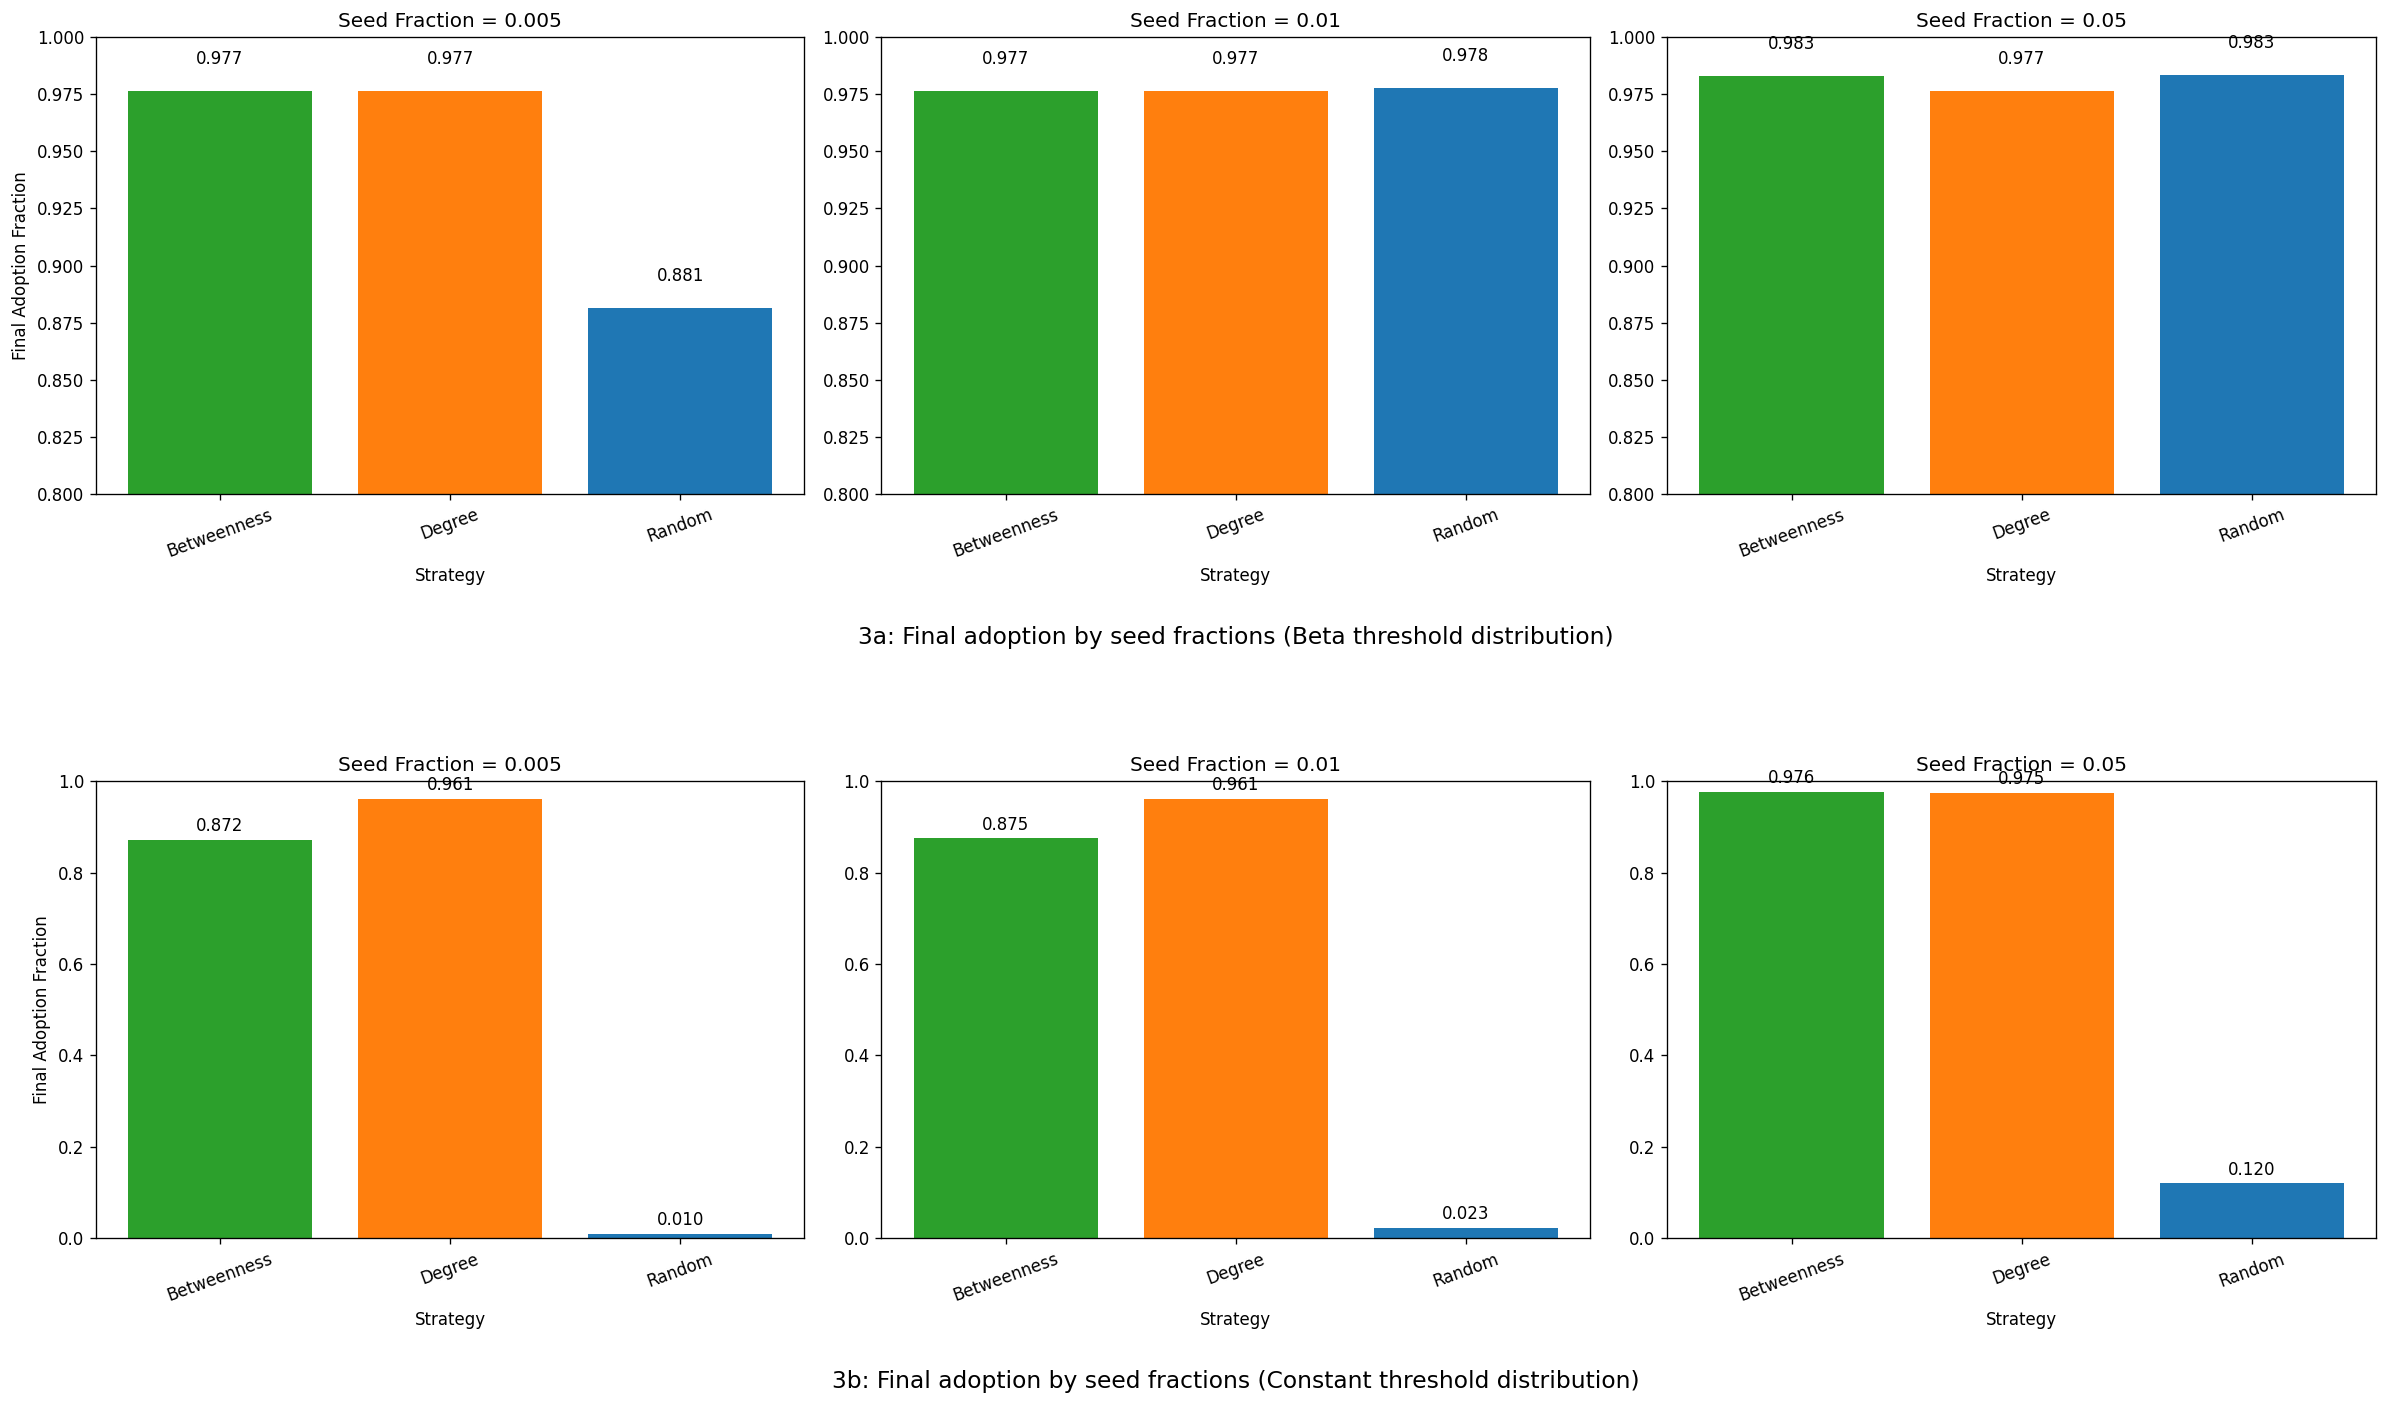

In [ ]:
colors = {
    "Random": "#1f77b4",
    "Degree": "#ff7f0e",
    "Betweenness": "#2ca02c"
}
def plot_final_adoption_combined(results_df_beta, results_df_const):
    fig = plt.figure(figsize=(20, 12))

    # grid: two barplot rows + caption rows
    gs = fig.add_gridspec(4, 3, height_ratios=[1, 0.15, 1, 0.15])

    def add_row(results_df, row_index, caption_text):
        for i, seed_frac in enumerate(seed_fractions):
            ax = fig.add_subplot(gs[row_index, i])
            subset = results_df[results_df["Seed_Fraction"] == seed_frac]

            # average final adoption per strategy
            mean_final = subset.groupby("Strategy")["Final_Adoption_Fraction"].mean()

            # bar colors
            bar_colors = [colors[strat] for strat in mean_final.index]

            # bar plot
            ax.bar(mean_final.index, mean_final.values, color=bar_colors)

            # add mean values on top of bars
            for x, y in zip(mean_final.index, mean_final.values):
                ax.text(x, y + 0.01, f"{y:.3f}", ha="center", va="bottom", fontsize=10)

            # title and axis styling
            ax.set_title(f"Seed Fraction = {seed_frac}")
            ax.set_xlabel("Strategy")
            ax.tick_params(axis="x", rotation=20)

            # y-axis range
            if mean_final.min() <= 0.5:
                ax.set_ylim(0, 1)
            else:
                ax.set_ylim(0.8, 1)

            if i == 0:
                ax.set_ylabel("Final Adoption Fraction")

        # caption row
        cap_ax = fig.add_subplot(gs[row_index + 1, :])
        cap_ax.axis("off")
        cap_ax.text(
            0.5, 0.5,
            caption_text,
            ha="center", va="center", fontsize=14
        )

    # Beta distribution row
    add_row(
        results_df_beta,
        0,
        "3a: Final adoption by seed fractions (Beta threshold distribution)"
    )

    # constant thresholds row
    add_row(
        results_df_const,
        2,
        "3b: Final adoption by seed fractions (Constant threshold distribution)"
    )

    # layout + save
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.savefig("final_adoption_combined.png", dpi=300, bbox_inches="tight")
    plt.show()


# Run the combined plot
plot_final_adoption_combined(results_df, results_df2)


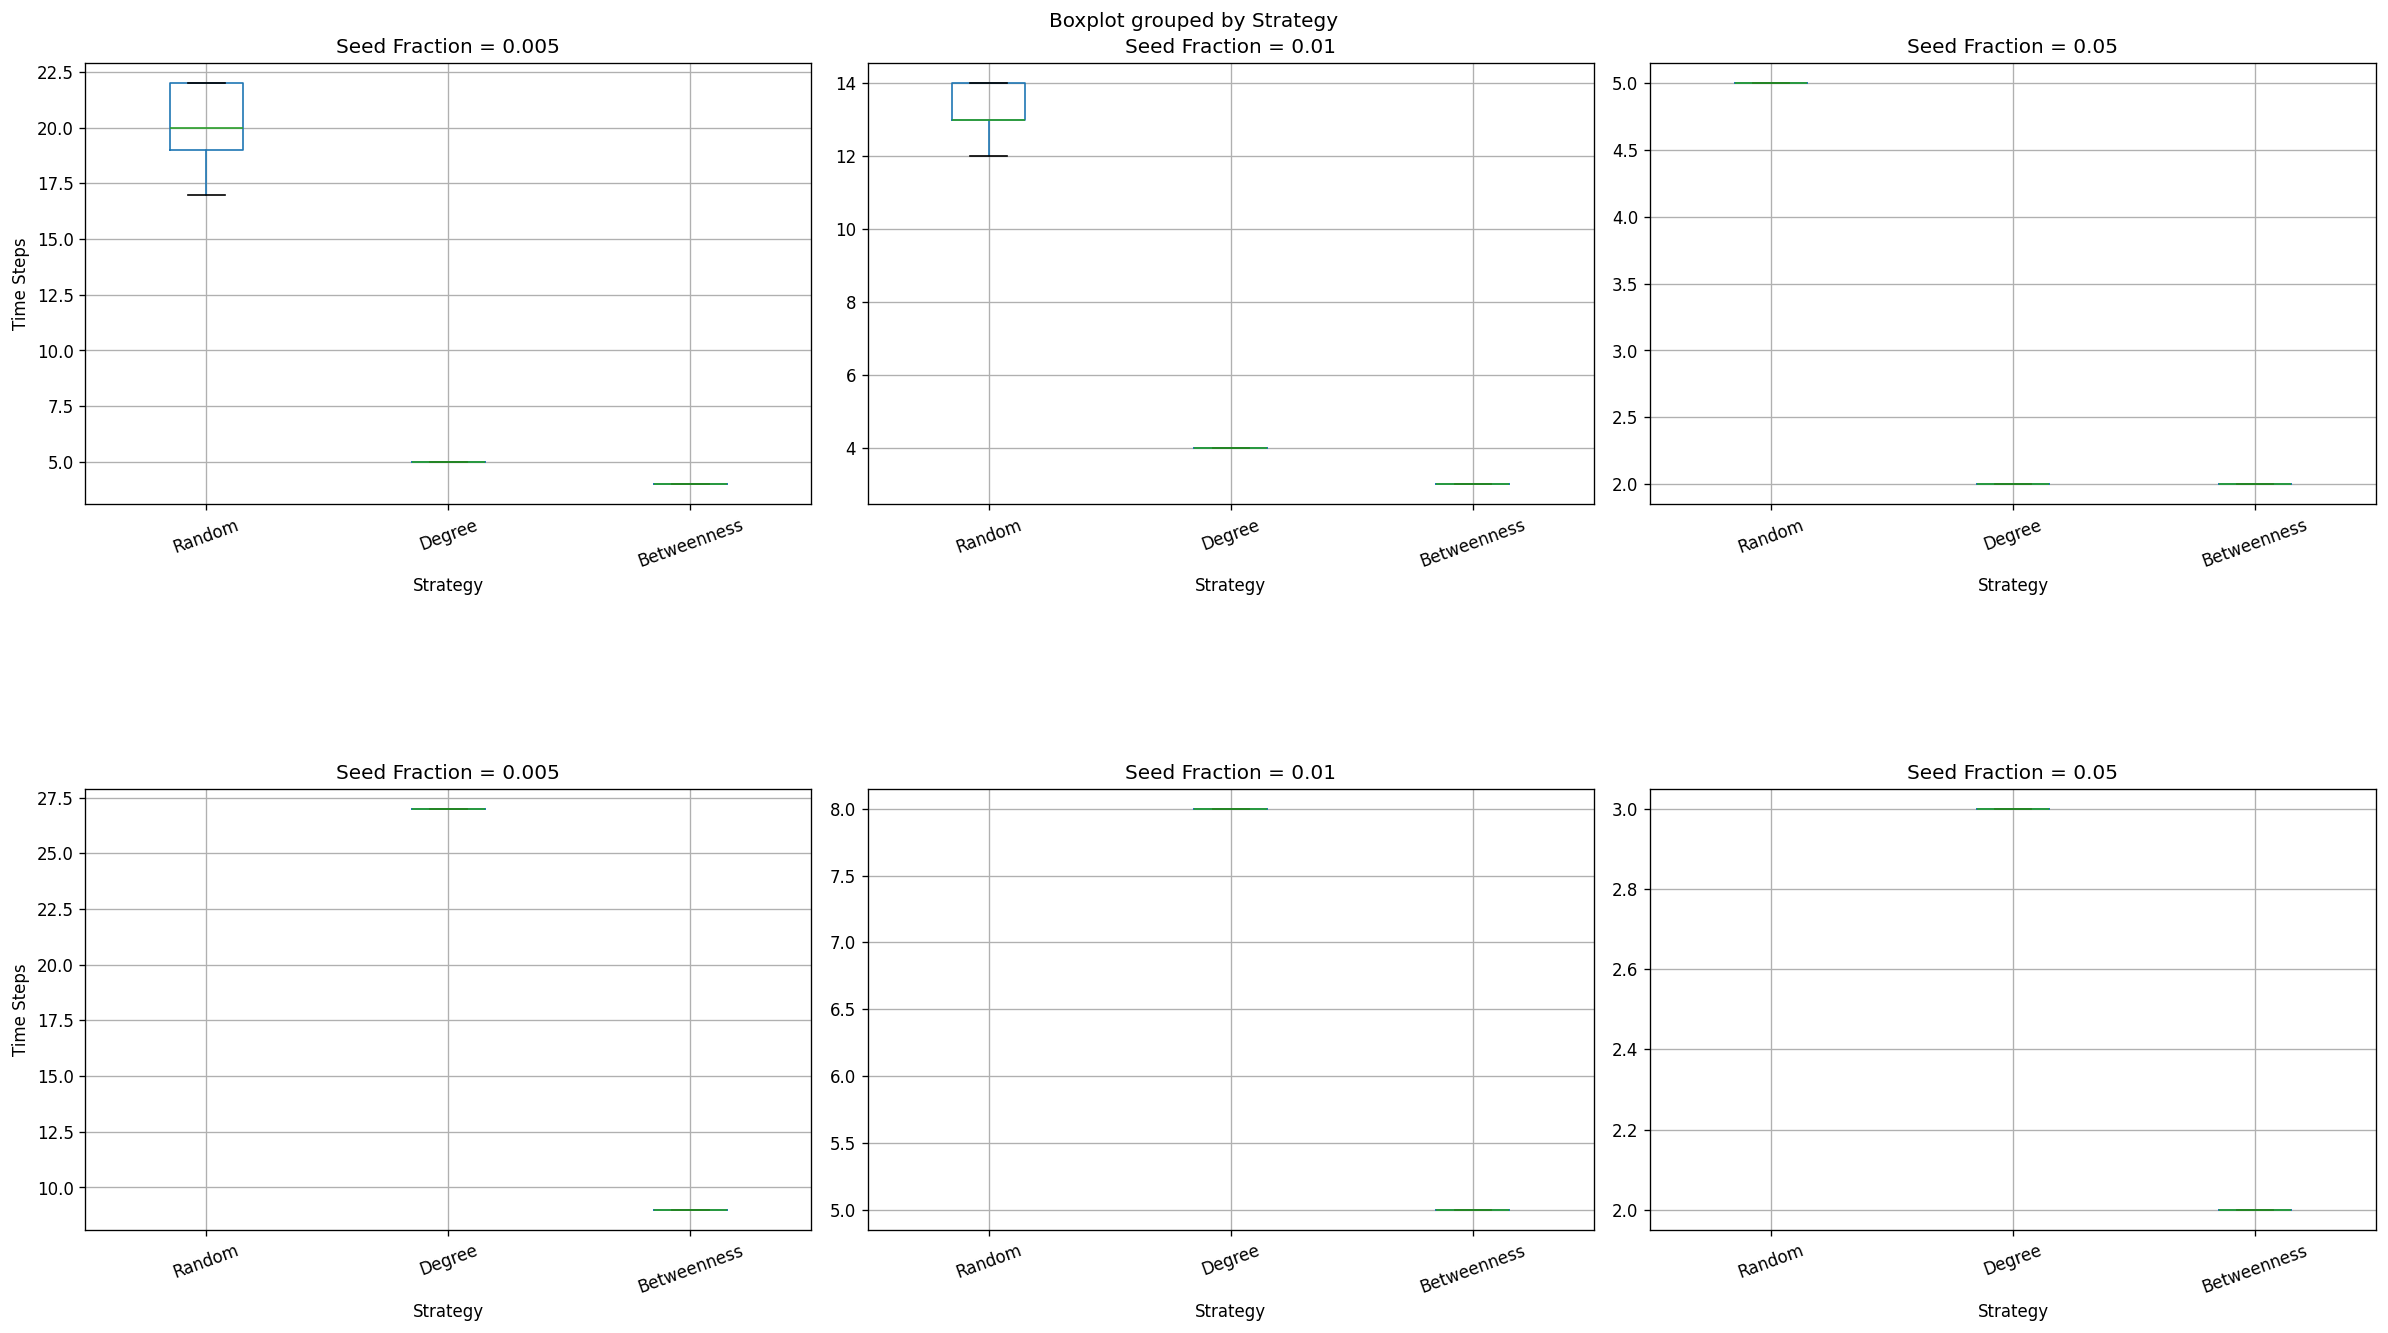

In [ ]:
def plot_time_to_50_combined(results_df_beta, results_df_const):
    fig = plt.figure(figsize=(20, 12))

    # layout: 2 plot rows + 2 caption rows
    gs = fig.add_gridspec(4, 3, height_ratios=[1, 0.15, 1, 0.15])

    def add_row(results_df, row_index, caption_text):
        for i, seed_frac in enumerate(seed_fractions):
            ax = fig.add_subplot(gs[row_index, i])
            subset = results_df[results_df["Seed_Fraction"] == seed_frac].copy()

            # ensure consistent strategy order
            subset["Strategy"] = pd.Categorical(
                subset["Strategy"],
                categories=["Random", "Degree", "Betweenness"],
                ordered=True
            )

            # boxplot
            subset.boxplot(
                column="Time_to_50%_Adoption",
                by="Strategy",
                ax=ax
            )

            ax.set_title(f"Seed Fraction = {seed_frac}")
            ax.set_xlabel("Strategy")
            ax.set_ylabel("Time Steps" if i == 0 else "")
            ax.set_xticklabels(["Random", "Degree", "Betweenness"], rotation=20)

        # caption row
        cap_ax = fig.add_subplot(gs[row_index + 1, :])
        cap_ax.axis("off")
        cap_ax.text(
            0.5, 0.5,
            caption_text,
            ha='center', va='center',
            fontsize=14
        )

    # Beta distribution row
    add_row(
        results_df_beta,
        0,
        "Figure 2a: Time to 50% adoption by seed fractions (Beta threshold distribution)"
    )

    # Constant distribution row
    add_row(
        results_df_const,
        2,
        "Figure 2b: Time to 50% adoption by seed fractions (Constant threshold distribution)"
    )

    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.savefig("time_to_50_adoption_combined.png", dpi=300, bbox_inches="tight")
    plt.show()
# Run the combined plot
plot_time_to_50_combined(results_df, results_df2)
